In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [40]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [42]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [44]:
# View all of the classes that automap found
for class_name in base.classes.keys():
    print(class_name)

measurement
station


In [45]:
# Save references to each table
station = base.classes.station
measurement= base.classes.measurement

In [46]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import sessionmaker

# Create a Session class bound to the engine
Session = sessionmaker(bind=engine)

# Instantiate a Session object to interact with the database
session = Session()


# Exploratory Precipitation Analysis

In [47]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
if most_recent_date:
    print(most_recent_date.date)


2017-08-23


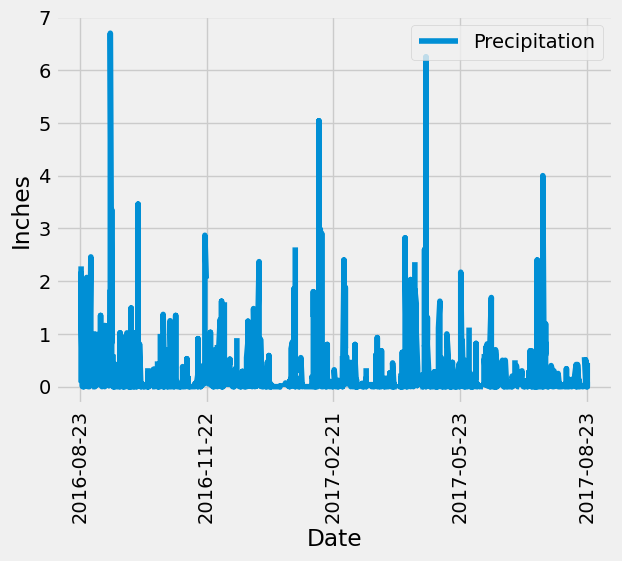

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date

if isinstance(most_recent_date, str):
    most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
    
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Convert 'Date' from string to datetime for plotting
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(df['Date'], df['Precipitation'], label='Precipitation')

# Formatting the x-axis to show only 5 dates
dates = pd.date_range(start=one_year_ago, end=most_recent_date, periods=5)
plt.xticks(dates, [date.strftime('%Y-%m-%d') for date in dates])  # Formatting dates as strings

plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.show()


In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df['Precipitation'].describe()
stats= pd.DataFrame(precipitation_stats)
stats.columns = ['Precipitation']
# Print stats 
stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [50]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first().station

temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
    ).filter(measurement.station == most_active_station).all()

min_temp, max_temp, avg_temp = temperature_stats[0]

(min_temp, max_temp, avg_temp)


(54.0, 85.0, 71.66378066378067)

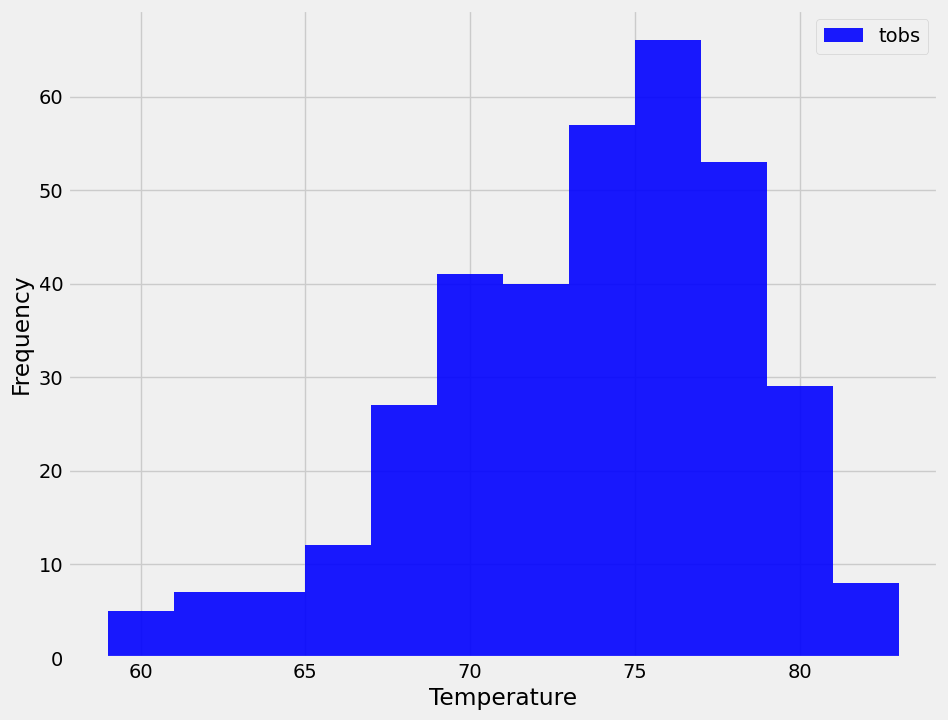

In [53]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_results = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago.strftime("%Y-%m-%d")).\
    order_by(measurement.date).all()

# Convert query results to a DataFrame
temps_df = pd.DataFrame(temperature_results, columns=['Temperature'])


# Plot the results as a histogram
plt.figure(figsize=(10, 8))
plt.hist(temps_df['Temperature'], bins=12, color='blue', alpha=0.9)
plt.legend(['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)


plt.show()

# Close Session

In [54]:
# Close Session
session.close()